In [4]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)


# Bayesian Hypothesis Testing

Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``

# Reference for Bayesian t-test


> Kruschke J, **Doing Bayesian Data Analysis**, Ch. 12

# da OpenIntro: RIPRENDERE IL T TEST, LA NOTAZIONE E QUALE CONCLUSIONE TRARREMMO NEL CASO FREQUENTISTA

# Drug trial evaluation

* We  want to  evaluate  of a drug that is supposed to increase intelligence.

* We have IQ measures  of:
    * 47 individuals receiving the drug  (treatment group)
    * 42 individuals  receiving the placebo (control group). 
    
* Some observations are however far from the mean.

In [6]:
iq_drug = np.array ([101,100,102,104,105,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,104,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,103,103,100,101,103,104,100,101])
iq_placebo = np.array ([ 99,101,100,101,99,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,98,99])



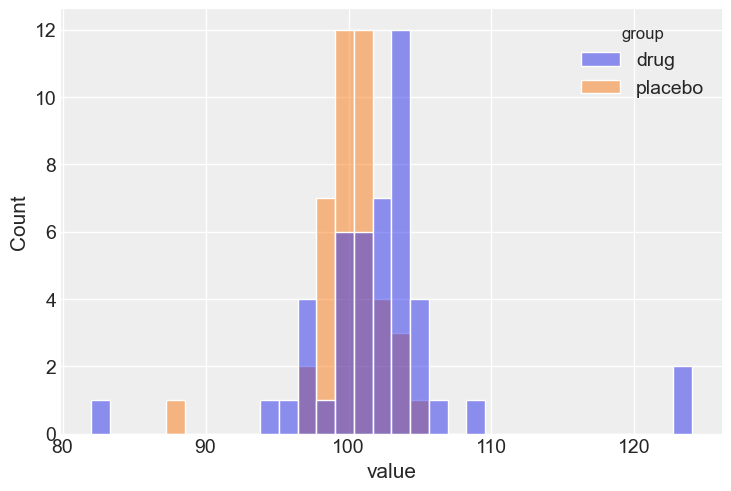

In [8]:
y  = pd.DataFrame(dict(value=np.r_[iq_drug, iq_placebo], group=np.r_[['drug']*len(iq_drug), ['placebo']*len(iq_placebo)]))
sns.histplot(data=y, x="value", hue="group");

# Research question
* The sample mean of Group 1 is superior, but there is a lot of variability within groups, and the variances of the two groups also appear to differ.
* There also appear to be some outliers.
* Are these groups credibly different?
* Is the drug credibly associated to a higher  IQ? 

# Research question

* We have two samples, from which we can compute sample properties:
    * observed means, also known as sample means: ($\bar{y}_1$, $\bar{y}_2$) 
    * sample standard deviations ($s_1, s_2$) 
    * numerosity ($n_1, n_2$)
* The sample are drawn from two populations, whose actual parameters ($\mu_1, \mu_2, \sigma_1, \sigma_2$) are unknown.
* Does the sample provide enough information, to conclude that $\mu_2 >  \mu_1$ with probability 95%?

## Likelihood

* We  assume the two populations to have their own means ($\mu_{\text{drug}}, \mu_{\text{placebo}}$) and standard deviations ($\sigma_1, \sigma_2$).


* The model parameters are $\mu_{\text{drug}}, \mu_{\text{placebo}}, \sigma_{\text{drug}}, \sigma_{\text{placebo}}$.


* Assuming a Gaussian likelihood function,  we have:

$$y^{(treat)}_i \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}})$$

$$y^{(placebo)}_i \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})$$

where $i$ refers to the $i$-th individual in the group.



# Prior information 

*  When designing the priors,  it is recommend to express any prior information that you have available. 

* The IQ can be interpreted according to the <a href="https://www.123test.com/interpretation-of-an-iq-score/"> IQ scale meaning </a>.

    * its  mean in the population is  about 100
    * the IQ is generally assumed to be normally distributed. 
    *  extreme values of IQ  are 60 ( cognitively impaired) and 140 (gifted). 
    * a plausible value of standard devation is about  10 , imposing 3 $\sigma$= 100 -70 = 130-100




*  We give to  standard deviations a Half-normal prior over a plausible range of values, recalling that in our case $s_{p} \approx 8.5$. 



# Prior for $\mu_{\text{drug}}$ and $\mu_{\text{placebo}}$

* We assign a normal prior to both means.
* The mean IQ of the population is 100 and extreme values of IQ are 60 and 140.
* We are unsure about the exact mean IQ, but it is reasonable to assume it to lie in (85, 115)
* Accordingly,  $p(\mu_{\text{drug}}) =  p(\mu_{\text{placebo}}) =  N (100, 5 )$
* We assign the same priors to both groups, so that we are not favoring a group over another a priori.

In [9]:
#Setting the prior for sigma, adjusting the scale to have the median of the halfnormal close to (100-60) /3 =~ 16
from scipy.stats import halfnorm
# this yields a  diffuse prior, but still defined over plausible range. 
pd.DataFrame(halfnorm.rvs(scale=25, size=10000)).describe()

#the prior for sigma is thus halfnormal(scale=25)

,0
count,10000.000000
mean,20.074950
std,15.121236
min,0.004151
25%,8.173971
50%,17.001151
75%,28.766190
max,95.651597


#  The probabilistic model

\begin{align}
\mu_{\text{drug}} & \sim N(100,5) \\
\mu_{\text{placebo}} & \sim N(100,5) \\
\sigma_1 & \sim \text{Halfnormal} (25) \\
\sigma_2 & \sim \text{Halfnormal} (25) \\
y_{\text{drug},i}  & \sim N(\mu_1, \sigma_1) \\
y_{\text{placebo}_i}  & \sim N(\mu_2, \sigma_2)\\
\end{align}


In [10]:
#full model

with pm.Model() as  diff_drug_model:
    mu_drug              = pm.Normal         ('mu_drug',          mu = 100,  sd = 5)
    mu_placebo        = pm.Normal          ('mu_placebo',    mu = 100,  sd = 5)
    sigma_drug         = pm.HalfNormal ('sigma_drug',      sigma=25)
    sigma_placebo   = pm.HalfNormal ('sigma_placebo', sigma=25)

    
    #likelihood for the two groups
    y_drug         = pm.Normal  ('y_1',  mu=mu_drug,      sigma=sigma_drug,       observed= iq_drug)
    y_placebo   = pm.Normal  ('y_2',  mu=mu_placebo, sigma=sigma_placebo, observed= iq_placebo)

# Comparing two means $\mu_1$ and $\mu_2$

To compare the means of the two populations we consider:
* the difference between the means of the populations:
$$\mu_1 - \mu_2$$ 

*  Cohen's d (*effect size*, more about it later): 
$$
\displaystyle
\frac{\mu_2 - \mu_1}{\sigma_P}$$ 

where  $\sigma_P$ is the pooled standard deviation,  $\sigma_P = \sqrt{ \frac{\sigma_2^2 + \sigma_1^2}{2} }$

* Effect size is  the amount of change induced by the treatment relative to the standard deviation. It is often used in medical studies.
* A conventionally “small” effect size in psychological research is 0.2 (Cohen, 1988),


* We  can define such indicators  as *deterministic* variables in PyMC3;  their sampled values will be part of the output.
* We can thus have their posterior distribution.

# Interpretation of Cohen's d values

$$
\displaystyle
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_2^2 + \sigma_1^2}{2}}}
$$

Guidelines:
* small  effect ($0 \leq d \leq 0.5$)
* medium effect  ($0.5 \leq d \leq 1$)
* large  effect ($d >  1$)

The same guidelines can be used to interpret negative values of  $d$.

In [11]:
with diff_drug_model:
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_drug - mu_placebo)
    effect_size         = pm.Deterministic('effect_size', diff_of_means / np.sqrt((sigma_drug**2 + sigma_placebo**2) / 2))
    trace                    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_placebo, sigma_drug, mu_placebo, mu_drug]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


# Did the sampler converge? Trace plot of parameters and deterministic variables

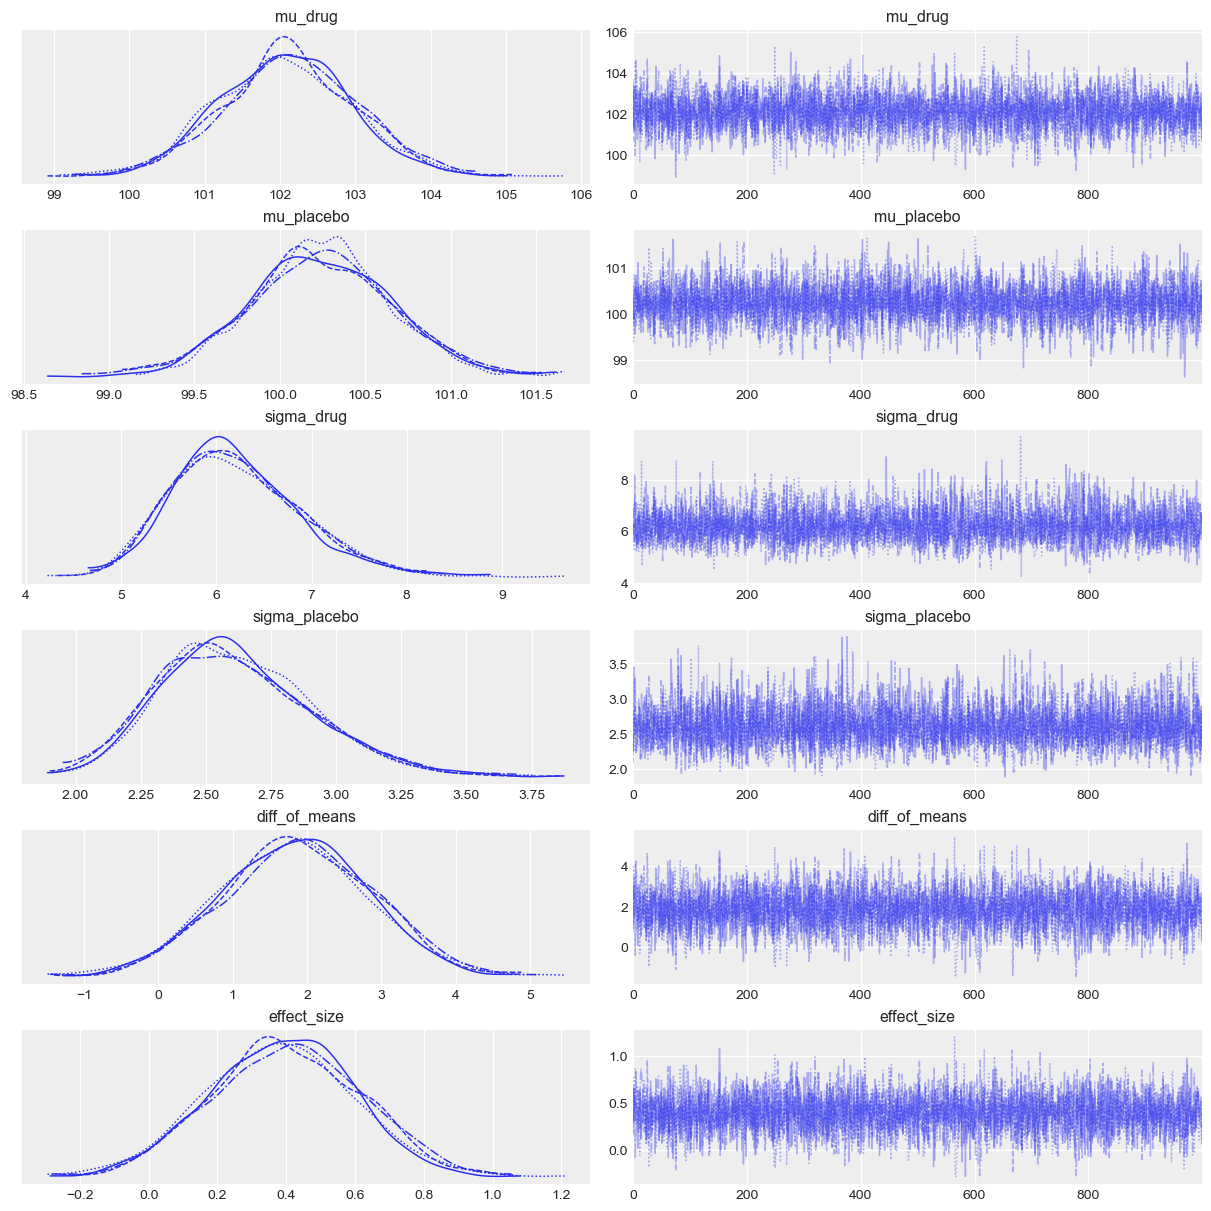

In [12]:
az.plot_trace(trace);

In [29]:
az.summary(trace,  hdi_prob=0.9)
#the hdi of the means of the two groups overlap.
#the hdi's of the two groups overlap (though by a rather narrow margin) and we cannot draw any strong conclusion

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_drug,102.10,0.90,100.58,103.48,0.01,0.01,"5,114.00","3,038.00",1.00
mu_placebo,100.24,0.42,99.56,100.94,0.01,0.00,"5,188.00","3,035.00",1.00
sigma_drug,6.21,0.67,5.17,7.32,0.01,0.01,"5,231.00","3,198.00",1.01
sigma_placebo,2.61,0.29,2.14,3.08,0.00,0.00,"5,773.00","2,851.00",1.00
diff_of_means,1.85,1.00,0.26,3.52,0.01,0.01,"5,067.00","2,714.00",1.00
effect_size,0.39,0.21,0.06,0.75,0.00,0.00,"4,894.00","2,803.00",1.00


# Posterior predictive checks

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


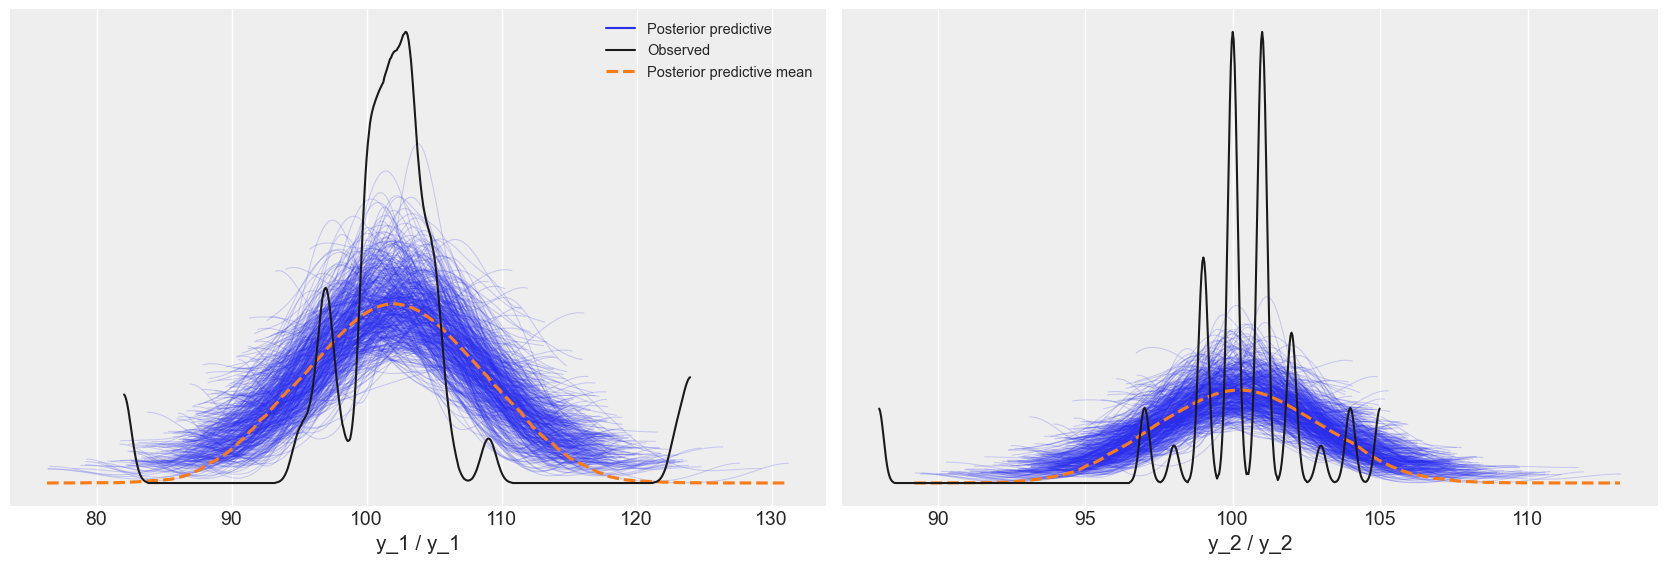

In [30]:
with diff_drug_model:
     ppc = pm.sample_posterior_predictive(trace, samples=500)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=diff_drug_model));

# Discussion
* The density is too low in the center of the distribution.
* For the moment, we continue the analysis with our current model.
* Later we will improve the model by making it robust.


# Assessing the credibility of the difference being 0
* We can assess the credibility of a certain value. 
* We are  interested in 0, which corresponds to the mean IQ being the same in the two groups. 
*  We thus  examine the posterior distribution of the credible parameter values and sees whether 0  falls in a region of high density or not.
* If the null value is far from the most credible values, we  reject it.

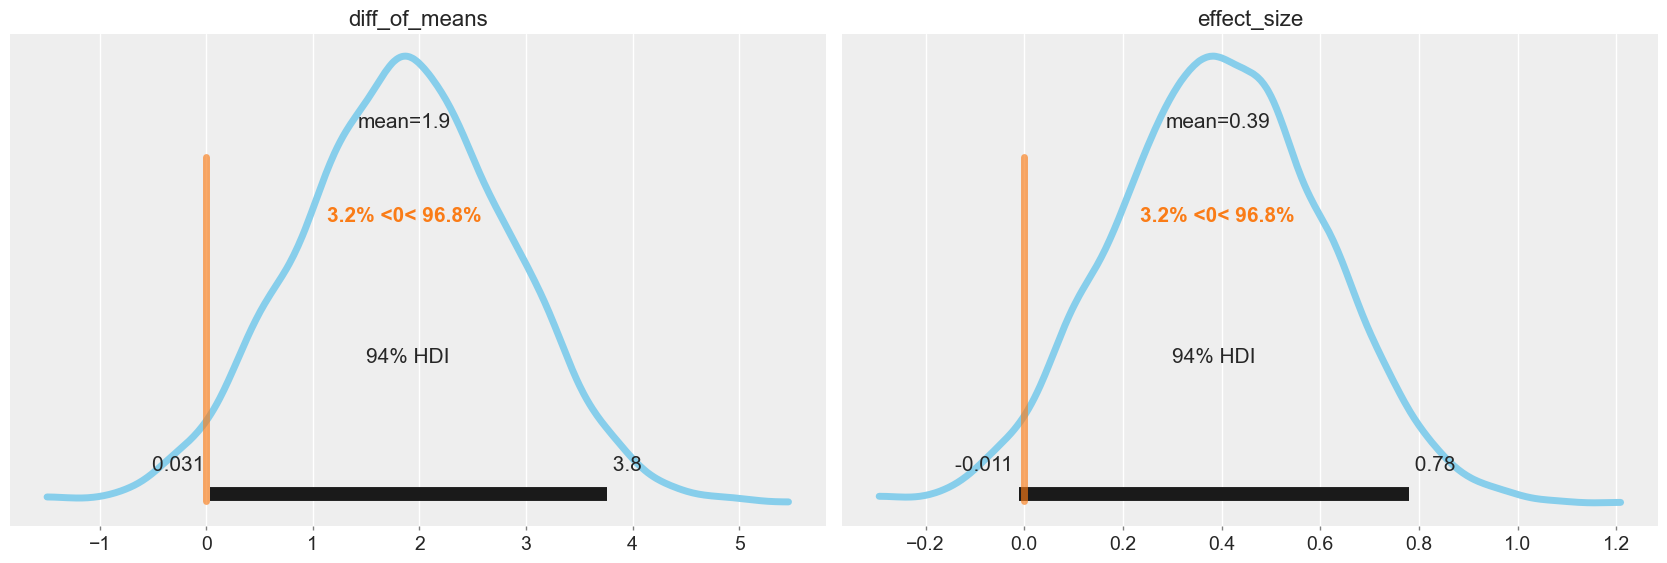

In [31]:
az.plot_posterior(trace, var_names=['diff_of_means','effect_size'],  ref_val=0, color='#87ceeb', linewidth=5);

# Posterior analysis of  the effect size

* The posterior probability of the effect size being small, medium, large are computed in the next slide.



# Discussion

* As the value of 0 is out of the 95 HDI, we can reject it: it is not plausible.
* The difference between the two means is 1.9 on average.
*  The 95% HDI of the difference of means falls well above zero, and about 97% of the credible values are greater than zero. 
* Thus the groups’ means are credibly different. 
* Bayesian analysis yields the posterior distribution of credible values, which we can use to take  conclusions


In [32]:
pd.options.display.float_format = '{:,.2f}'.format
d  = az.extract_dataset(trace, var_names="effect_size")
effect=pd.DataFrame(d.effect_size, columns=["effect_size"])
bins = [0, 0.5, 1, 100]
res   = pd.cut(effect["effect_size"],bins= bins).value_counts() / len(effect)
res

#given the data and the prior, there is 67%  probability of effect size being small, 30% of being medium, 0 of being large.

(0.0, 0.5]     0.66
(0.5, 1.0]     0.31
(1.0, 100.0]   0.00
Name: effect_size, dtype: float64

## Robust likelihood
We could choose  a Student-t distribution to describe the distributions of the scores in each group. This choice adds robustness to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution.
As already discussed, we use a Student-t distribution with 4 degrees of freedom, in oder to filer outlieres.

Thus, the likelihood functions of our model are specified as follows:

$$y_{\text{drug},i} \sim T(\nu=4, \mu_{\text{drug}}, \sigma_{\text{drug}})$$

$$y_{\text{placebo},i} \sim T(\nu=4, \mu_{\text{placebo}}, \sigma_{\text{placebo}})$$


In [39]:
with pm.Model() as model_t:
    #prior are  unchanged.
    mu_drug_t              = pm.Normal         ('mu_drug_t',          mu = 100,  sd = 5)
    mu_placebo_t        = pm.Normal          ('mu_placebo_t',    mu = 100,  sd = 5)
    sigma_drug_t         = pm.HalfNormal ('sigma_drug_t',      sigma=25)
    sigma_placebo_t    = pm.HalfNormal ('sigma_placebo_t', sigma=25)

    #But now we adopt a robust likelihood. 
    #For simplicity we use a Student T with nu=4.  A more sophisticated approach would be to put a prior also on nu, but
    #that makes the model more complex to sample. 
    group1 = pm.StudentT ('drug',       nu=4, mu=mu_drug_t,       sd=sigma_drug_t,       observed= iq_drug)
    group2 = pm.StudentT ('placebo', nu=4, mu=mu_placebo_t,  sd=sigma_placebo_t, observed= iq_placebo)
    
    #Derived quantities:
    diff_of_means_t = pm.Deterministic('diff_of_means_t', mu_drug_t - mu_placebo_t)
    effect_size_t         = pm.Deterministic('effect_size_t', diff_of_means_t / np.sqrt((sigma_drug_t**2 + sigma_placebo_t**2) / 2))
    trace_t     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_placebo_t, sigma_drug_t, mu_placebo_t, mu_drug_t]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


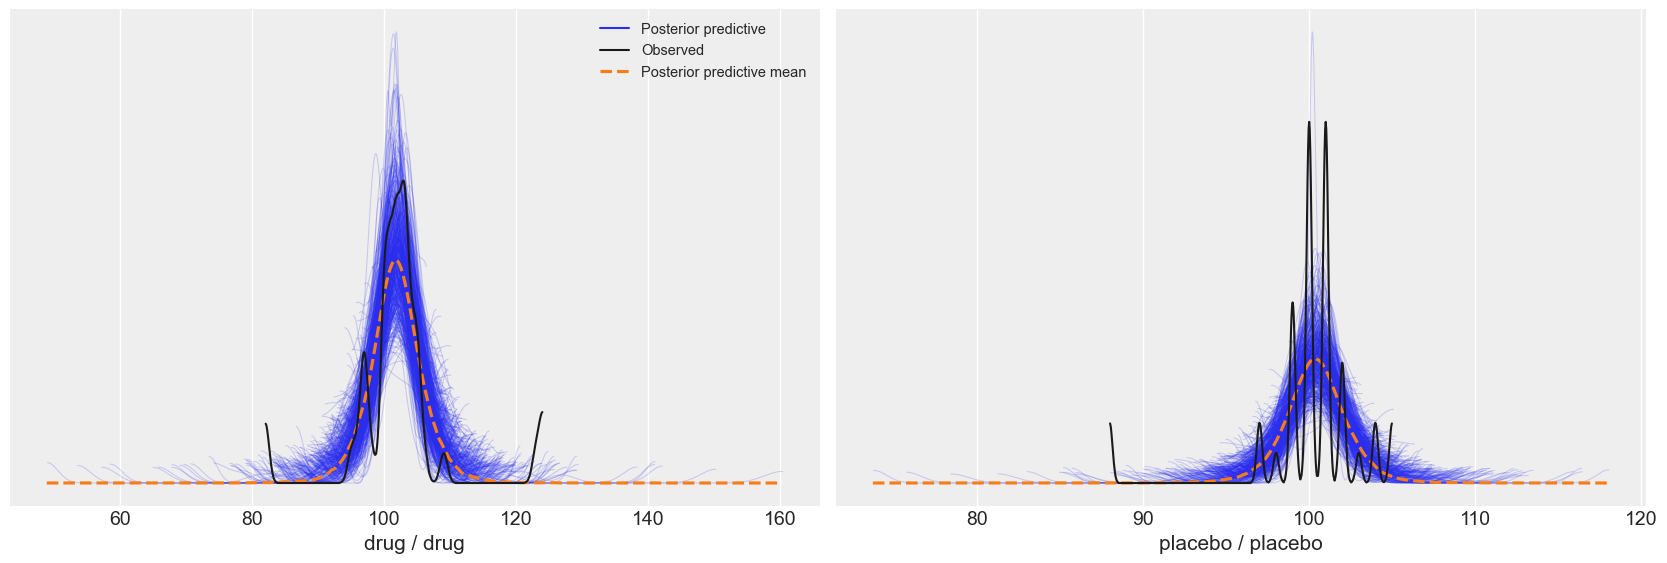

In [43]:
#the fit is better compare to the normal model, though not yet perfect for the placebo group.
with robust_model:
    ppc_t = pm.sample_posterior_predictive(trace_t, samples=500)
    az.plot_ppc(az.from_pymc3(posterior_predictive=   ppc_t, model= model_t));

In [46]:
# the sigma decreases by almost a half compared to the Gaussian model, as the student distribution filters outliers.
# as a results, the hdi become shorter, and now there is longer overlap between the hdi of the two groups.
# we can thus conclude that there significant difference between the means of the two groups.
pd.concat( [az.summary(robust_trace_t,  hdi_prob=0.9), az.summary(trace, hdi_prob=0.9) ])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_drug_t,101.80,0.51,100.97,102.61,0.01,0.01,"4,925.00","2,992.00",1.00
mu_placebo_t,100.43,0.25,100.01,100.83,0.00,0.00,"5,179.00","2,904.00",1.00
sigma_drug_t,3.00,0.47,2.26,3.76,0.01,0.01,"5,129.00","3,049.00",1.00
sigma_placebo_t,1.41,0.23,1.04,1.77,0.00,0.00,"5,224.00","2,995.00",1.00
diff_of_means_t,1.36,0.56,0.43,2.27,0.01,0.01,"4,904.00","2,857.00",1.00
effect_size_t,0.59,0.26,0.16,0.99,0.00,0.00,"5,142.00","2,897.00",1.00
mu_drug,102.10,0.90,100.58,103.48,0.01,0.01,"5,114.00","3,038.00",1.00
mu_placebo,100.24,0.42,99.56,100.94,0.01,0.00,"5,188.00","3,035.00",1.00
sigma_drug,6.21,0.67,5.17,7.32,0.01,0.01,"5,231.00","3,198.00",1.01
sigma_placebo,2.61,0.29,2.14,3.08,0.00,0.00,"5,773.00","2,851.00",1.00


In [51]:
pd.options.display.float_format = '{:,.2f}'.format
d_t  = az.extract_dataset(trace_t, var_names="effect_size_t")
effect=pd.DataFrame(d_t.effect_size_t, columns=["effect_size_t"])
bins = [0, 0.5, 1, 100]
res   = pd.cut(effect["effect_size_t"],bins= bins).value_counts() / len(effect)
res

#given the data and the prior, there is 67%  probability of effect size being small, 30% of being medium, 0 of being large.

(0.5, 1.0]     0.58
(0.0, 0.5]     0.35
(1.0, 100.0]   0.06
Name: effect_size_t, dtype: float64

# Exercise (to be solved also by us).
* It is quite common to assume that two groups have the same standard deviation $\sigma$ rather than two independent standard deviations $\sigma_1$ and $\sigma_2$.
* Rework the model accordingly and verify via WAIC which model variant provides the best fit to the data.
* Point out your conclusion analyzing the posterior distribution of the difference of the means and the Cohen mean using the chosen model.

In [62]:
with pm.Model() as model_t2:
    #prior are  unchanged.
    mu_drug_t              = pm.Normal         ('mu_drug_t',          mu = 100,  sd = 5)
    mu_placebo_t        = pm.Normal          ('mu_placebo_t',    mu = 100,  sd = 5)
    sigma_both                = pm.HalfNormal  ('sigma_both',      sigma=25)


    #But now we adopt a robust likelihood. 
    #For simplicity we use a Student T with nu=4.  A more sophisticated approach would be to put a prior also on nu, but
    #that makes the model more complex to sample. 
    group1 = pm.StudentT ('drug',       nu=4, mu=mu_drug_t,       sd=sigma_both,       observed= iq_drug)
    group2 = pm.StudentT ('placebo', nu=4, mu=mu_placebo_t,  sd=sigma_both,      observed= iq_placebo)
    
    #Derived quantities:
    diff_of_means_t2 = pm.Deterministic('diff_of_means_t2', mu_drug_t - mu_placebo_t)
    effect_size_t2         = pm.Deterministic('effect_size_t2', diff_of_means_t2 / np.sqrt((sigma_both**2 + sigma_both**2) / 2))
    trace_t2                   = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_both, mu_placebo_t, mu_drug_t]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8889562991936397, but should be close to 0.8. Try to increase the number o

In [64]:
#forse per usare WAIC bisogna scrivere il modello in forma vettoriale? altrimenti trova due likelihood, una per ogn gruppo
az.compare({'model_t':trace_t, 'model_t2':model_t2}, ic='waic')

TypeError: Encountered error in ic computation of compare.